In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot

import networkx as nx
from numpy.linalg import inv
import os
import random
from tqdm.notebook import tqdm, trange
from scipy.integrate import solve_ivp
import time
import pickle

## Generate Reservoirs

In [2]:
def W_res(K,n,eig_rho):
    # # ER network n*n and its radius is eig_rho
    prob = K/(n-1)
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            b = np.random.random()
            if (i != j) and (b < prob):
                W[i, j] = np.random.random()

    rad = max(abs(np.linalg.eigvals(W)))
    W_reservoirr = W*(eig_rho/rad)  

    return W_reservoirr

def ResNet_Generator(Na, K, eig_rho):
    GNet = W_res(K,Na,eig_rho)
    G = nx.DiGraph(GNet)
    N = GNet.shape[0]
    Nodes_res=N
    return G, GNet, N

def RC_InpNodes_Generator(N, InpNodes_Frac):
        W_in_a=InpNodes_Frac
        dim = 2
        W_in = np.zeros((N,dim+1))      # N,4
        fact = (N/(dim))
        for i in range(N):
            W_in[i,int(i/fact)] = W_in_a*(2*np.random.random() - 1)
        W_in[:,-1] = W_in_a*(2*np.random.random() - 1)
        Winp0 = W_in[:,-1]
        Winp1= W_in[:,0]
        Winp2= W_in[:,1]
        return Winp0, Winp1, Winp2 

# Input -> Duffing Oscillator

Forced Duffing oscillator is described by:

d^2x/d^2t + c*dx/dt + k*x + beta*x^3 = f*sin(omega*t+phi)

conversion into 1st-order ordinary differential equation (state-space representation)

New set of variables:
    q1 = x
    q2 = dq1/dt = dx/dt

Transformation of ODE:
    dq1/dt = q2
    dq2/dt = -c*q2 -k*q1 +f*sin(omega*t+phi)

Notation in vector form:
    q = [q1, q2]^T
    F = [0, f*sin(omega*t+phi)]^T

    [dq/dt] = [[A]]*[q] + [F]

    state matrix A
    [[A]] = [[0, 1], [-k, -c]]
    
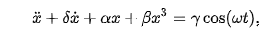

In [3]:
def Plot(a, b, forcing):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 1.5
    plt.rcParams["figure.figsize"] = fig_size 
    plt.figure()
    plt.subplot(3, 1, 1)
    plt.plot(a[:1000], lw=0.5, color='black')
    plt.ylabel(r'$q_1(t)$')
    plt.title('damped forced oscillator')

    plt.subplot(3, 1, 2)
    plt.plot(b[:1000], lw=0.5, color='black')
    plt.ylabel(r'$q_2(t)$')

    plt.subplot(3, 1, 3)
    plt.plot(forcing[:1000], lw=0.5, color='red')
    plt.xlabel(r'$t$')
    plt.ylabel(r'$f(t)$')
    plt.tight_layout()
    plt.show()

    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 1.5; fig_size[1] = 1.5
    plt.rcParams["figure.figsize"] = fig_size 
    plt.plot(a, b, lw=0.5)
    plt.scatter(a[0], b[0], marker='o',c='r')
    plt.xlabel(r'$q_1(t)$'); plt.ylabel(r'$q_2(t)$')
    plt.show()

def one_dof_oscillator(t, q: np.ndarray,
                       c: float = 0.1,
                       k: float = 1.0,
                       f: float = 0,
                       omega: float = 1.0,
                       phi: float = 0.0,
                       beta: float=0
                       ) -> np.ndarray:
    """ ODE one-dimensional oscillator. """

    A = np.array([[0, 1], [-k, -c]])
    B = np.array([[0, 0], [-beta, 0]])
    F = np.array([0, f*np.cos(omega*t+phi)])

    return np.dot(A, q) + np.dot(B, q*q*q) + F

def FreqGenerator(f, omega, t, phi):
    return np.array([0, f*np.sin(omega*t+phi)])

def SolveDuffing(q0, t_eval, c, k, f, omega, phi, beta):
    # numerical time integration
    sol_forced = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]], y0=q0,\
                           t_eval=t_eval, args=(c, k, f, omega, phi, beta))

    # display of trajectories
    q = sol_forced.y.T
    t = sol_forced.t
    forcing = f*np.cos(omega*t+phi)  
    # Plot(q[:, 0], q[:, 1], forcing) 
    return q, forcing

def InputGenerator(t_eval,Trans,c,k,f,omega,phi,beta,q0):
    Q_i=[];Forcing_i=[]
    for i in range(len(f)):
        Qs, Fs = SolveDuffing(q0, t_eval, c, k, f[i], omega, phi, beta)
        Q_i.append(Qs); Forcing_i.append(Fs)
    
    Q_i=np.asarray(Q_i); Forcing_i=np.asarray(Forcing_i)   
    
    #####Input##################
    Inp0=[]; Inp1=[]; Inp2=[]
    for i in range(len(f)):
        Inp0.append(Forcing_i[i,Trans:])
        Inp1.append(Q_i[i,Trans:,0])
        Inp2.append(Q_i[i,Trans:,1])
    
    #####Plot##################
    for i in range(len(f)):
        Plot(Inp1[i], Inp2[i], Inp0[i])
    
    return np.asarray(Inp0), np.asarray(Inp1), np.asarray(Inp2)

def Reservoir(GNet, Init, Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha):
    Nodes_res = GNet.shape[0]; 
    Npts_U = len(Inp1)

    R = np.zeros([N, Npts_U])
    R[:,0] = Init
    
    ####time loop
    for t in range(0, Npts_U-1):      
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T) +\
                    Winp0*Inp0[t] + Winp1*Inp1[t] + Winp2*Inp2[t])
    return R

def Ridge_Regression(N, R, gamma, V_train):
    W_out = np.dot(np.dot(V_train, R.T), np.linalg.inv((np.dot(R, R.T) + gamma*np.identity(N))))
    return W_out

def RC_Train_and_Test(TransRes, GNet, Init, Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha, gamma):
    Res_i=np.zeros((Inp0.shape[0], N, Inp0.shape[1]-TransRes))
    for i in trange(Inp0.shape[0]):
        Res_i[i] = Reservoir(GNet, Init, Inp0[i], Inp1[i], Inp2[i], Winp0, Winp1, Winp2, N, alpha)[:,TransRes:]

    ##### Removing Transients from Inp and Res after RC run###########################################
    Inp0=Inp0[:,TransRes:].flatten(); Inp1=Inp1[:,TransRes:].flatten(); Inp2=Inp2[:,TransRes:].flatten()
    Res=[]
    for i in range(len(f)):
        Res.append(Res_i[i].T)
    Res=np.reshape(np.asarray(Res), (Res_i.shape[0]*Res_i.shape[2], Res_i.shape[1])).T
    
    ##### Training#####################################################################################
    W_out_inp1 = Ridge_Regression(N, Res, gamma, Inp1)
    W_out_inp2 = Ridge_Regression(N, Res, gamma, Inp2)
    
    print('Res Shape: ', Res.shape, '\n', 'Wouts shape: ', W_out_inp1.shape, W_out_inp2.shape)
    return Res, Inp0, Inp1, Inp2, W_out_inp1, W_out_inp2

def Testing(GNet, Init, Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha, W_out_inp1, W_out_inp2):
    Res_test = Reservoir(GNet, Init, Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha)

    Inp1_out_test = np.dot(W_out_inp1, Res_test)
    Inp2_out_test = np.dot(W_out_inp2, Res_test)

    # print(Res_test.shape, Inp1_out_test.shape)
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 3; fig_size[1] = 3
    plt.rcParams["figure.figsize"] = fig_size 
    plt.plot(Inp1, Inp2, lw=0.5, c='b', label='Original')
    # plt.scatter(Inp1[0], Inp2[0], marker='o', c='k')
    plt.plot(Inp1_out_test[100:], Inp2_out_test[100:], lw=0.5, c='red', label='Train Fit')
    # plt.scatter(Inp1_out_test[0], Inp2_out_test[0], marker='D',c='g')
    plt.xlabel(r'$q_1(t)$'); plt.ylabel(r'$q_2(t)$')
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

# Autonomous RC functions

In [4]:
def Autonomous_Reservoir(GNet, Init, T_Run, Inp0, Winp0, Winp1, Winp2, N, alpha, W_out_inp1, W_out_inp2):   
    R = np.zeros([N, T_Run])
    R[:, 0] = Init
    Inp1_pred = np.zeros(T_Run); 
    Inp2_pred = np.zeros(T_Run); 
        
    #### time loop
    for t in range(0, T_Run-1):     
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T)\
                    + Winp0*Inp0[t] + Winp1*Inp1_pred[t] + Winp2*Inp2_pred[t])
        
        Inp1_pred[t+1] = np.dot(W_out_inp1, R[:,t+1])
        Inp2_pred[t+1] = np.dot(W_out_inp2, R[:,t+1])
        
    return R, np.asarray([Inp1_pred, Inp2_pred])

def LocalMinMax_Finder(X):
    X_max=[]; X_min=[]
    for i in range(X.shape[0]):
        X_max_j=[]; X_min_j=[]
        for j in range(X.shape[2]-2):
            if(X[i,0,j+2] - X[i,0,j+1])<0 and (X[i,0,j+1] - X[i,0,j])>0:
                X_max_j.append(X[i,0,j+1])
            if(X[i,0,j+2] - X[i,0,j+1])>0 and (X[i,0,j+1] - X[i,0,j])<0:
                X_min_j.append(X[i,0,j+1])
        X_max.append(X_max_j); X_min.append(X_min_j)

    return X_max, X_min

def Bifurcation_Plot(par, X_max, X_min, Color, Title):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
    plt.title(Title)
    for i in range(len(par)):
        ax.plot(np.repeat(par[i], len(X_max[i])), X_max[i], c=Color[0], marker='o', markersize=0.15, linestyle='None')
#         ax.plot(np.repeat(par[i], len(X_min[i])), X_min[i], c=Color[1], marker='o', markersize=0.15, linestyle='None')

    # ax.set_xlim([0.39,0.61])
    # ax.set_ylim([-1.7,1.7])
    ax.set_xlabel(r'$f$', fontsize='22')
    ax.set_ylabel(r'$x_{max}$', fontsize='22')
    # ax.tick_params(axis="x", direction='in', length=10, width=2, pad=15)
    # ax.tick_params(axis="y", direction='in', length=10, width=2, pad=10)
    ax.tick_params(labelsize=15)
    # plt.title('beta={:.2f}, W_in_a={:.2f}, alpha={:.2f}, eig_rho={:.2f}\nNt={:d}, Np={:d}, wa={:d}, transit={:d},n={:d},k={:d}'\
    #          .format(beta, W_in_a, alpha, eig_rho, Nt, Np, wa, transit,n,k))
    plt.show()

    
def Trajectory_Plots(fs,PlotPars, OX, PX):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 8; fig_size[1] = 8
    fig, axs = plt.subplots(3, 3)
    plt.rcParams["figure.figsize"] = fig_size 
    p=0
    for i in range(3):
        for j in range(3):
            axs[i,j].set_title('f={:.4f}'.format(fs[PlotPars[p]]))
            axs[i,j].plot(OX[PlotPars[p],0,500:], OX[PlotPars[p],1,500:], lw=0.5, c='b', label='Original')
            axs[i,j].plot(PX[PlotPars[p],0,500:], PX[PlotPars[p],1,500:], lw=0.5, c='red', label='Prediction')
            p+=1
    for ax in axs.flat:
        ax.set(xlabel=r'$q_1(t)$', ylabel=r'$q_2(t)$')
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

def Bifurcation_Original(c, k, fs, omega, phi, beta, t_eval, q0, Colors):
    Qs_Original=[]
    for i in trange(len(fs)):
        #### numerical time integration
        sol_forced = solve_ivp(one_dof_oscillator, t_span=[t_eval[0], t_eval[-1]],
                               y0=q0, t_eval=t_eval, args=(c, k, fs[i], omega, phi, beta))
        Qs_Original.append(sol_forced.y)
    Qs_Original=np.asarray(Qs_Original)
    
    X_max, X_min = LocalMinMax_Finder(Qs_Original[:,:,1000:])
    Bifurcation_Plot(fs, X_max, X_min, Colors, 'Original')
    
    return Qs_Original
        
def Bifurcation_Predict(fs, omega, phi, t_eval, GNet, Init, T_Run, Winp0, Winp1, Winp2,\
                        N, alpha, W_out_inp1, W_out_inp2, Colors,BifTrans):
    Qs_Pred=[];Rs_Pred=[]
    for i in trange(len(fs)):
        #####External forcing for prediction##################
        forcing = fs[i]*np.sin(omega*t_eval+phi)
                
        ####Predict RC run###################################
        # Init = np.random.random(N)*0.1
        R_auto, Qi_Pred = Autonomous_Reservoir(GNet, Init, T_Run, forcing,\
                                Winp0, Winp1, Winp2, N, alpha, W_out_inp1, W_out_inp2)
        Qs_Pred.append(Qi_Pred)
        Rs_Pred.append(R_auto)
    
    
    Qs_Pred=np.asarray(Qs_Pred); Rs_Pred=np.asarray(Rs_Pred)
    X_max, X_min = LocalMinMax_Finder(Qs_Pred[:,:,BifTrans:])
    Bifurcation_Plot(fs, X_max, X_min, Colors, 'Prediction')
    
    return Qs_Pred, Rs_Pred
print("done")

done


# Save Data and models

In [5]:
def SaveData(SaveDir, Typ, Rep):
    DOFO_Params = {"c":c, "k":k, "f":f, "omega":omega, "phi":phi, "beta":beta, "q0":q0, "T":T, "h":h, "Trans":Trans}
    RC_Train_Params = {"Na":Na, "K":K, "eig_rho":eig_rho, "InpNodes_frac":InpNodes_Frac, "TransRes":TransRes, "alpha":alpha,\
                 "Init":Init, "gamma":gamma, "h":h, "Trans":Trans, "G":G, "GNet":GNet, "N":N, "Winp0":Winp0, "Winp1":Winp1,\
                 "Winp2":Winp2}
    RC_Predict_Params = {"P_T":P_T, "P_Init":P_Init, "BifTrans":BifTrans, "P_c":P_c, "P_k":P_k, "P_fs":P_fs, "P_omega":P_omega,\
                         "P_phi":P_phi, "P_beta":P_beta, "P_q0":P_q0}
    RC_Trained_Data = {"Res":Res, "Inp0":Inp0, "Inp1":Inp1, "Inp2":Inp2, "W_out_inp1":W_out_inp1, "W_out_inp2":W_out_inp2}
    RC_Predict_Data = {"Qs_Pred":Qs_Pred, "Rs_Pred":Rs_Pred}
    
    nx.write_gpickle(DOFO_Params, os.path.join(SaveDir,'DOFO_Params_{:}.gpickle'.format(Typ)))
    nx.write_gpickle(RC_Train_Params, os.path.join(SaveDir,'RC_Train_Params_{:}_Rep{:d}.gpickle'.format(Typ, Rep)))
    nx.write_gpickle(RC_Predict_Params, os.path.join(SaveDir,'RC_Predict_Params_{:}_Rep{:d}.gpickle'.format(Typ, Rep)))
    nx.write_gpickle(RC_Trained_Data, os.path.join(SaveDir,'RC_Trained_Data_{:}_Rep{:d}.gpickle'.format(Typ, Rep)))
    nx.write_gpickle(RC_Predict_Data, os.path.join(SaveDir,'RC_Predict_Data_{:}_Rep{:d}.gpickle'.format(Typ, Rep)))
    

# Parameters

In [6]:

######### Duffing Oscillator parameters####################################
c = 0.32    # damping
k = -1.0     # linear stiffness
f = [0.49, 0.51]#[0.49, 0.53] # #[0.46, 0.49, 0.51]    # forced case
omega = 1.5 #1.46 #1.47 #1.5
phi = 0
beta=1

#### initial conditions
q0 = np.array([0.05, 0.05])

#### time integration interval
T=700; h=0.1; Trans=500
t_eval = np.arange(start=0, stop=T, step=h)
#####ResNet Parameters ###################################################
Na = 100 
K=50;
eig_rho = 0.5057 #0.4057#1.1
InpNodes_Frac = 0.2 #0.25

##### RC params############################################################
TransRes=400
alpha = 0.2 #0.5 #0.1 #0.09999999999
Init = np.random.random(Na)*0.1 #np.zeros(Na)
gamma = 5e-8

##########################################################################
##### Prediction RC params############################################################
P_T=2000; 
P_T_Run = int(P_T/h)
P_Init = np.random.random(Na)*0.1 #np.zeros(Na) #np.random.random(Na)*0.1
BifTrans = 1000
##### Test Ground truth Duffing########################
# model parameters
P_c = c    # damping
P_k = k     # linear stiffness
P_fs = np.arange(0.1,0.8,0.005) #np.arange(0.1,0.8,0.01)     # forced case
P_omega = omega#1.5
P_phi = phi
P_beta=beta

P_q0 = np.array([0.05, 0.05])

# time integration interval
P_t_eval = np.arange(start=0, stop=P_T, step=h)

O_Colors = ['b', 'green']
P_Colors = ['r', 'green']

print(len(P_fs), P_T_Run)

140 20000


Generating original bifurcation diagram :


  0%|          | 0/140 [00:00<?, ?it/s]

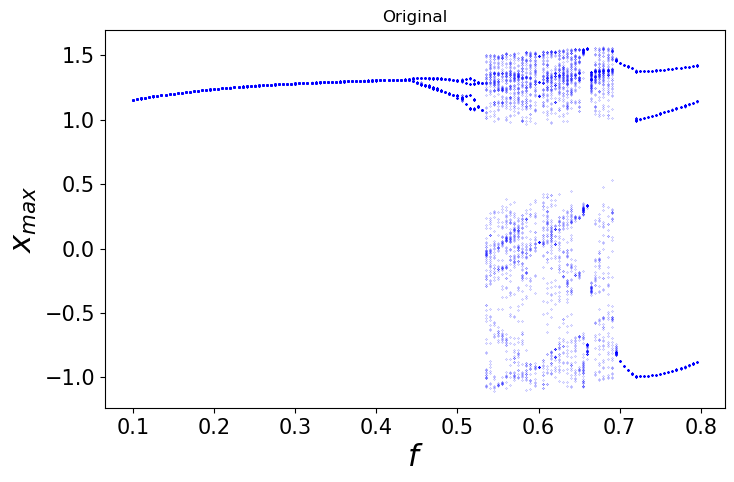

In [7]:
print('Generating original bifurcation diagram :')
Qs_Original = Bifurcation_Original(P_c, P_k, P_fs, P_omega, P_phi, P_beta, t_eval, P_q0, O_Colors)

# Run RC

Rep: 0
Input generation:


C:\Users\manis\AppData\Local\Temp\ipykernel_47116\3416959599.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


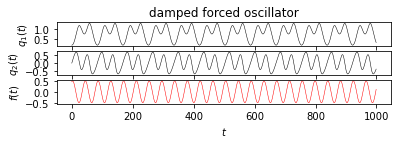

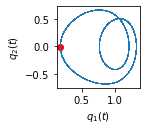

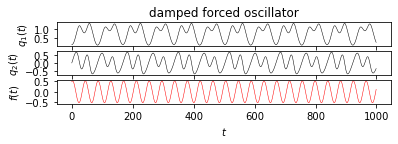

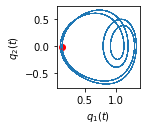

gdsjdjs (2, 6500)
ResNet and Input weights creation:
ResNet shape:  100 (100, 100)
RC run and training:


  0%|          | 0/2 [00:00<?, ?it/s]

Res Shape:  (100, 12200) 
 Wouts shape:  (100,) (100,)
Input shapes:  (12200,) (12200,) (12200,)
Testing :


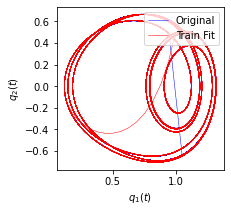

Predictions :


  0%|          | 0/140 [00:00<?, ?it/s]

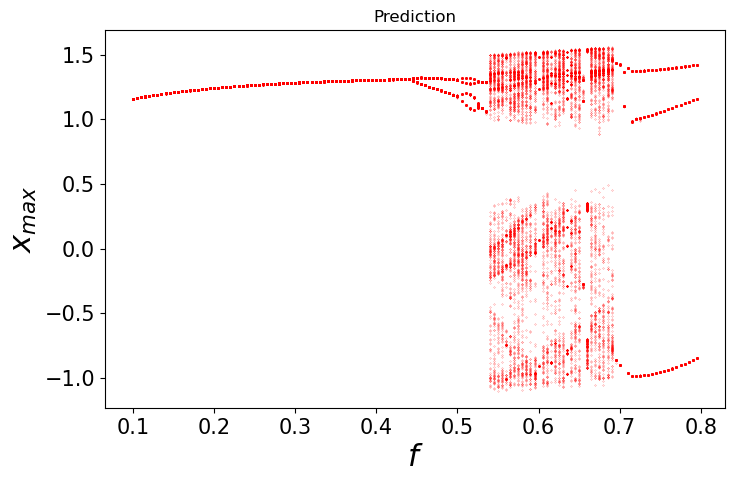

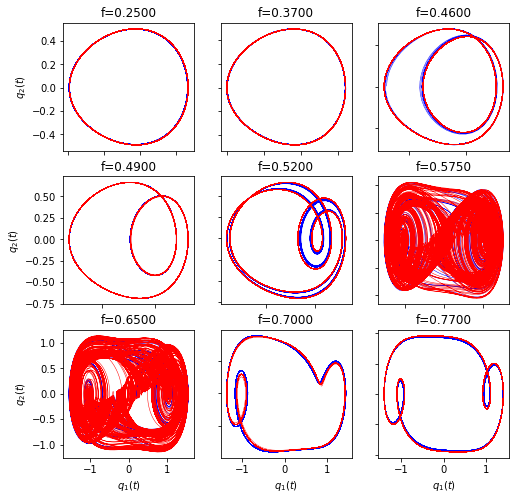

In [8]:
#### Save Directory
SaveDir = "C:/Work/TU-Berlin/Projects/1.RC_from_Scratch/Manuscript/Data/1D/"
SaveDat='No'

for Rp in range(1):
    print('Rep:', Rp)
    ####### Solve Duffing for given params and Fs #######################
    print('Input generation:')
    Inp0, Inp1, Inp2 = InputGenerator(t_eval,Trans,c,k,f,omega,phi,beta,q0)
    print("gdsjdjs",Inp0.shape)

    ###### Generating ResNet and Inp weights Run and Train###############
    print('ResNet and Input weights creation:')
    G, GNet, N = ResNet_Generator(Na, K, eig_rho)
    print('ResNet shape: ', N, GNet.shape)
    Winp0, Winp1, Winp2 = RC_InpNodes_Generator(N, InpNodes_Frac)
    
    ####Init Params#####################################################
    Init = np.zeros(Na) #np.random.random(Na)*0.1 #np.zeros(Na)
    P_Init = np.zeros(Na) #np.random.random(Na)*0.1
    
    #####RC Run and Train################################################
    print('RC run and training:')
    Res, Inp0, Inp1, Inp2, W_out_inp1, W_out_inp2 = RC_Train_and_Test(TransRes, GNet, Init,\
                                    Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha, gamma)
    print('Input shapes: ',Inp0.shape, Inp1.shape, Inp2.shape)

    #####Testing################################################
    print('Testing :')
    Testing(GNet, Init, Inp0, Inp1, Inp2, Winp0, Winp1, Winp2, N, alpha, W_out_inp1, W_out_inp2)

    ######Testing################################################
    print('Predictions :')
    Qs_Pred, Rs_Pred = Bifurcation_Predict(P_fs, P_omega, P_phi, P_t_eval, GNet, P_Init, P_T_Run,\
                            Winp0, Winp1, Winp2, N, alpha, W_out_inp1, W_out_inp2, P_Colors, BifTrans)
    
    #####Some Plots###########################
    PlotPars=[30,54,72,78,84,95,110,120,134]
    # PlotPars=[5,15,28,23,37,30,42,55,69]
    Trajectory_Plots(P_fs,PlotPars, Qs_Original, Qs_Pred)
    
    ####Save or Not#############################
    if SaveDat=='Yes':
        Typ='A';
        SaveData(SaveDir, Typ, Rp)

# print(Qs_Original.shape, Qs_Pred.shape, Rs_Pred.shape)

## Load test

In [ ]:
# Loadtst = nx.read_gpickle(os.path.join(SaveDir,'RC_Train_Params_{:}_Rep{:d}.gpickle'.format(Typ, 0)))
# Loadtst